# Model Testing
After training 5 machine learning models (logistic regression, decision tree, random forest, LightGBM & a neural<br/>
network), the purpose of this notebook is to test the performance of each using the previously unused test data.<br/>
This will let us determine which model is the most accurate in detecting Acute Kidney Failure in unseen patients.<br/>
The metric for scoring the models will remain AUC.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
# Set up paths & import src functions
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_folder = os.path.join(project_root, 'src')
sys.path.insert(0, src_folder)
from modeling import *
from s3_storage import *

In [3]:
# Import data
X_train = from_s3(bucket='mimic-jamesi',
                  filepath='data/acute_kidney_failure_X_train.npy')
X_test = from_s3(bucket='mimic-jamesi',
                 filepath='data/acute_kidney_failure_X_test.npy')
y_train = from_s3(bucket='mimic-jamesi',
                  filepath='data/acute_kidney_failure_y_train.npy')
y_test = from_s3(bucket='mimic-jamesi',
                 filepath='data/acute_kidney_failure_y_test.npy')

In [4]:
def run_final_test(model, X_test, y_test):
    '''
    Function that imports a trained model from AWS S3, and runs it on the
    test data. The output is the AUC score on the test data.
    '''
    m = from_s3(bucket='mimic-jamesi', filepath='models/{}'.format(model))
    predict = m.predict_proba(X_test)
    score = roc_auc_score(y_test, predict[:,-1])
    print("{} score: ".format(model), score)
    return score

In [5]:
# Import the trained models and run on the test data
logistic_score = run_final_test('logistic_regression', X_test, y_test)
dt_score = run_final_test('decision_tree', X_test, y_test)
rf_score = run_final_test('random_forest', X_test, y_test)
lightgbm_score = run_final_test('light_gbm', X_test, y_test)
nn_score = run_final_test('neural_network', X_test, y_test)

logistic_regression score:  0.8473821401576503
decision_tree score:  0.8554605334197172
random_forest score:  0.8801820537738905
light_gbm score:  0.867031854011446


Using TensorFlow backend.


neural_network score:  0.8736095454054636


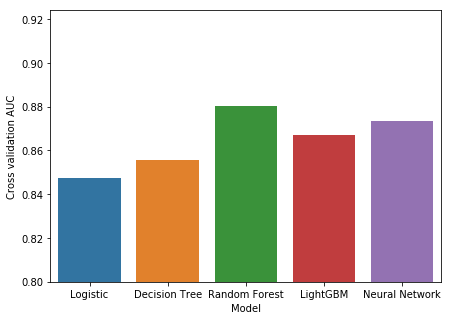

In [6]:
# Visualise the final AUC scores
names = ['Logistic', 'Decision Tree', 'Random Forest',
         'LightGBM', 'Neural Network']
scores = [logistic_score, dt_score, rf_score, lightgbm_score, nn_score]
plt.figure(figsize = (7, 5))
sns.barplot(names, scores)
plt.ylim(0.8)
plt.xlabel('Model')
plt.ylabel('Cross validation AUC')
plt.show()

Feature importances for the Random Forest model:


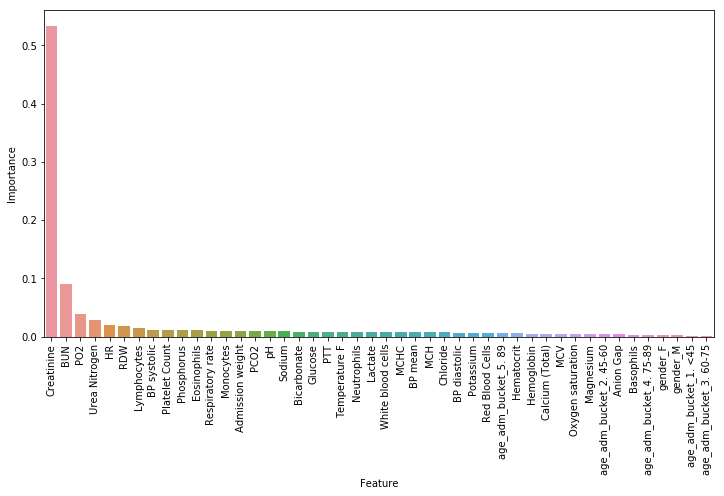

,Importance
Creatinine,0.533581
BUN,0.090503
PO2,0.038616
Urea Nitrogen,0.027964
HR,0.019411
RDW,0.018806
Lymphocytes,0.013886
BP systolic,0.011455
Platelet Count,0.011350
Phosphorus,0.011032


In [7]:
# Inspect feature importances for the Random Forest
rf = from_s3(bucket='mimic-jamesi',
             filepath='models/random_forest')

feature_names = from_s3(bucket='mimic-jamesi',
                        filepath='data/acute_kidney_failure_feature_names.npy')

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = feature_names,
                                   columns=['Importance']).sort_values('Importance',ascending=False)

features = feature_importances.index.tolist()
feature_scores = feature_importances.Importance.tolist()
plt.figure(figsize = (12, 6))
sns.barplot(features, feature_scores)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation='vertical')
print('Feature importances for the Random Forest model:')
plt.show()

feature_importances

## Conclusion

Running the models on the test data gives the surprise conclusion that the LightGBM (which scored the highest on<br/>
cross validation testing) is only the 3rd most accurate model on the test data. The cross validation score for<br/>
LightGBM was 0.889 but on the test data scored only 0.867, indicating that LightGBM could be overfitting on the<br/>
cross validation data. On the other hand, the random forest, which scored 0.879 in cross validation accuracy,<br/>
produced a nearly identical score of 0.88 on the test data, indicating that the model is well generalised for<br/>
unseen patients. The neural network, which had the 3rd best cross validation score of 0.869, improved on the<br/>
test data (scoring 0.874), also indicating it generalises well.<br/><br/>

Looking at the feature importances of the random forest gives a promising indication of the model's validity. By<br/>
far the most important feature is Creatinine, with the 2nd most important being BUN. This is promising because<br/>
both of these tests are commonly accepted measures of kidney function in medical practice. See:<br/>
https://www.mayoclinic.org/tests-procedures/creatinine-test/about/pac-20384646 and<br/>
https://www.mayoclinic.org/tests-procedures/blood-urea-nitrogen/about/pac-20384821<br/><br/>

Furthermore, the fact that these two features are so important in comparison to the remaining features indicates<br/>
that for this problem a complex model (such as a neural network) isn't needed and in fact a random forest, which<br/>
is much more simple in terms of implementation, has shorter training times and conceptually is much more easily<br/>
interpretable, also had a superior classification accuracy.<br/><br/>

In terms of next steps, more work should be done to control for additional factors, most importantly the presence<br/>
of comorbidities and also to control for any drugs which may have been taken by the patients.